In [96]:
import numpy as np
import matplotlib
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [97]:
path = Path(r"C:\Users\chris\Downloads")

files = list(path.glob("OBJFile*.obj"))

In [98]:
letter_freq = defaultdict(int)

for f in tqdm(files):
    with open(f, "r") as file:
        for line in file.readlines():
            for char in line:
                if line.startswith("#"): continue
                letter_freq[char] += 1

100%|██████████| 46/46 [03:00<00:00,  3.93s/it]


In [99]:
plot_letter_freq = letter_freq.copy()
plot_letter_freq["newline"] = plot_letter_freq.pop("\n")
plot_letter_freq["space"] = plot_letter_freq.pop(" ")
plot_letter_freq

defaultdict(int,
            {'v': 16922637,
             '-': 18923555,
             '0': 194482792,
             '.': 50497634,
             '4': 72360651,
             '6': 67596784,
             '5': 81739103,
             '7': 63404127,
             '2': 87891981,
             '1': 99273184,
             '3': 77866843,
             '8': 61314403,
             '9': 57459043,
             'f': 29787272,
             'e': 2903,
             'newline': 46709887,
             'space': 140129727})

In [100]:
sum(letter_freq.values()), sum(letter_freq.values())/len(files), sum(letter_freq.values())/len(files)*8/8e6

(1166362526, 25355707.086956523, 25.355707086956524)

          v         -          0         .         4         6         5  \
0  16922637  18923555  194482792  50497634  72360651  67596784  81739103   

          7         2         1         3         8         9         f     e  \
0  63404127  87891981  99273184  77866843  61314403  57459043  29787272  2903   

    newline      space  
0  46709887  140129727  


<Axes: >

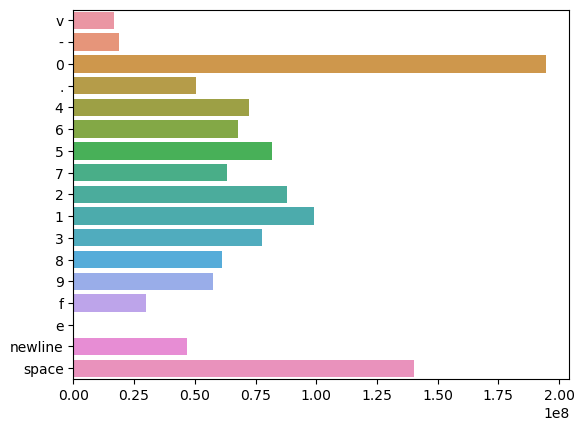

In [101]:
df = pd.DataFrame(data=plot_letter_freq, index=[0])
print(df.head())
sns.barplot(data=df, orient="h")

In [102]:
from collections import namedtuple

Node = namedtuple("Node", ["count", "letter", "left", "right"])

nodes = [Node(v, k, None, None) for k, v in letter_freq.items()]

In [103]:
def combine_nodes(a, b):
    return Node(a.count + b.count, "\0", a, b)

In [104]:
from heapq import heapify, heappop, heappush

heap = nodes.copy()
heapify(heap)

while len(heap) != 1:
    a = heappop(heap)
    b = heappop(heap)
    heappush(heap, combine_nodes(a, b))

huff_tree = heap[0]

In [105]:
def is_leaf(node: Node):
    return node.left is None and node.right is None

def make_table(node, path, table):
    # print(node)
    if node is None:
        return
    elif is_leaf(node):
        table[node.letter] = path
        return
    else:
        make_table(node.left, path + "0", table)
        make_table(node.right, path + "1", table)


huff_table = {}

make_table(huff_tree, "", huff_table)

huff_table

{'1': '000',
 '9': '0010',
 '8': '0011',
 '7': '0100',
 'f': '01010',
 'e': '0101100',
 'v': '0101101',
 '-': '010111',
 '6': '0110',
 '4': '0111',
 ' ': '100',
 '3': '1010',
 '5': '1011',
 '2': '1100',
 '\n': '11010',
 '.': '11011',
 '0': '111'}

In [115]:
file_path = Path("test_obj.obj")
out_file_path = Path("test_bin_obj.obj")

with open(file_path, "r") as f:
    file_data = f.read()

len(file_data)

53936214

In [117]:
import sys

data = ""
binary = b""
with open(out_file_path, "wb") as out:
    for char in tqdm(file_data):
        data += huff_table[char]
        if len(data) >= 8:
            out.write(int(data[:8], 2).to_bytes(1, "little"))
            data = data[8:]

    if len(data):
        out.write(int(data.ljust(8, "0")),2).to_bytes(1, "little")

  0%|          | 0/53936214 [00:00<?, ?it/s]

100%|██████████| 53936214/53936214 [00:24<00:00, 2210406.70it/s]


TypeError: BufferedWriter.write() takes exactly one argument (2 given)

In [119]:
import gzip

with gzip.open(out_file_path.stem + "_comp_gzip.gz", "wb") as out, open(out_file_path, "rb") as in_file:
    out.writelines(in_file)